<a href="https://colab.research.google.com/github/CoWoGeo/PUS2022_CWolk/blob/main/HW4/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fed's description: Exploratory spatial data analysis of CitiBike data using pysal and geopandas

# 0. Importing and Installing Libraries and Geospatial Libraries

In [142]:
!pip install geopandas
!apt install python3-rtree
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
#install mapclassify to plot quantiles
!pip install mapclassify
# For the CitiBike sections
#import Shapely tools to make my own points! I don't actually need LineString
from shapely.geometry import Point, LineString

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1 Working with a Shape File of Census Tracts

1.1 Loading Census Tract GeoJSON File given by Fed

In [143]:
ct_shape = gpd.read_file("https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=GeoJSON")

I added the below code based on class, but I guess it's not needed, maybe because it is already in a GeoJSON?

In [144]:
# ct_map = gpd.GeoDataFrame.from_file (I intentionally didn't finish this)

In [145]:
ct_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2165 entries, 0 to 2164
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      2165 non-null   object  
 1   shape_area   2165 non-null   object  
 2   ntaname      2165 non-null   object  
 3   shape_leng   2165 non-null   object  
 4   boro_name    2165 non-null   object  
 5   puma         2165 non-null   object  
 6   ct2010       2165 non-null   object  
 7   boro_code    2165 non-null   object  
 8   cdeligibil   2164 non-null   object  
 9   boro_ct2010  2165 non-null   object  
 10  ctlabel      2165 non-null   object  
 11  geometry     2165 non-null   geometry
dtypes: geometry(1), object(11)
memory usage: 203.1+ KB


Above, all the data types except geometry are in object. 12 columns, only one is missing an entry.

Coordinate system: I know this step is later, but I was curious.It's EPSG:4326, which is unprojected.

In [146]:
ct_shape.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Tested out plotting the data below. It wouldn't let me plot it in pink!

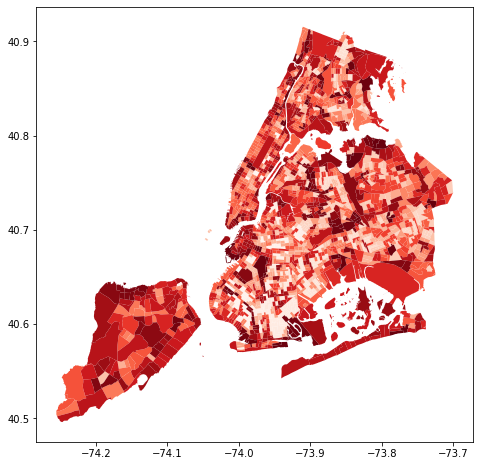

In [147]:
ax = ct_shape.plot(cmap="Reds", figsize=(8, 8))

## 1.2 Coordinate systems, projections, and transformations : 

Changing the CRS to New York State Plane Long Island Zone, used for NYC.

In [148]:
ct_shape = ct_shape.to_crs("EPSG:2263")

Just seeing how it looks! Emmanuel pointed out that the axes change units when you have correctly changed to a projected coordinate system.

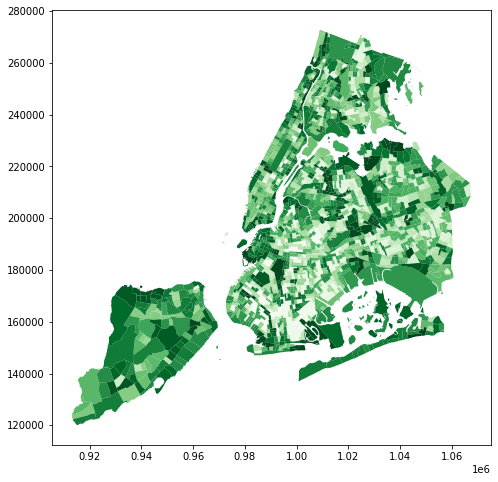

In [149]:
ax = ct_shape.plot(cmap="Greens", figsize=(8, 8))

Double-checking that it's in the right CRS now.

In [150]:
ct_shape.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Visualize the Census Tract Boundaries Colored by Boroughs

Fed notes: the file you read in into a geodataframe, which I will call generically ```gpd``` in these instructions, contains the "boro_code" column. To color by a column value (and the column can be numerical or categorical) you pass the column name to ```gdp.plot``` as
```gdp.plot(column="columnName")```

I had trouble making sense of the bundle of example code and getting it to work, so I broke it down step by step. Here is just the chloropleth.

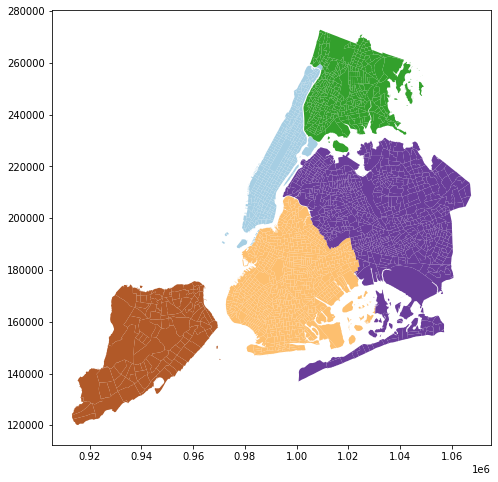

In [151]:
ax = ct_shape.plot(column="boro_code", cmap="Paired", figsize=(8, 8))

And here is the way we're instructed to do it. I find some of the plot vs plt vs ax vs fig confusing. I tried reading about it online and most of the explanations just confused me more.

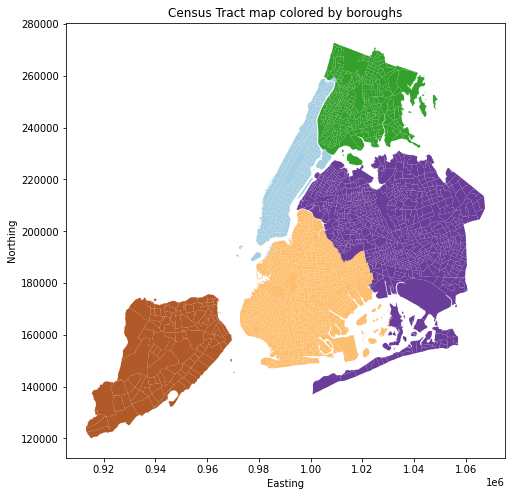

In [152]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ct_shape.plot(column="boro_code", alpha=1, linewidth=0.5,
              ax=ax, cmap="Paired")
plt.title("Census Tract map colored by boroughs");

### Measure Areas

**On epsg.io  look up the EPSG:2263. What is the accuracy when this projection is used in NYC?**

It looks like the accuracy is two meters, though at the bottom, they say to use NAD83(HARN) / SPCS for applications with an accuracy of better than 3 feet.



Making a column of shape area in square feet!

In [153]:
ct_shape["shape_area"] = ct_shape.geometry.area

In [154]:
ct_shape["shape_area"]

0       2.497010e+06
1       1.906016e+06
2       1.860993e+06
3       1.864600e+06
4       1.890907e+06
            ...     
2160    2.640076e+06
2161    2.685748e+06
2162    2.591319e+06
2163    1.621656e+06
2164    8.120950e+05
Name: shape_area, Length: 2165, dtype: float64

Now converting that to square miles and adding a column for it.

In [155]:
ct_shape["shape_areami2"] = ct_shape["shape_area"]*3.587e-8

Emmanuel pointed out that we needed to change those Google calculator options to be square feet and square miles.

Finding the total square mileage of NYC:

In [156]:
# I know this line is redundant, but it's helpful for me to break it down.
ct_shape["shape_areami2"].sum()

302.1329029228141

In [157]:
NYC_Area = ct_shape["shape_areami2"].sum()
print ('The total NYC land area is {:.0f} square miles.'.format(NYC_Area))

The total NYC land area is 302 square miles.


### Choropleths of NYC

*Fed notes I'm leaving in for me to refer to later: To make a choropleth of your python geodataframe (gdp) you can use, like before but this time with a numerical column:*

```gdp.plot(column="theNameOfMyColumn")```

*The problem is that the column has to be numeric. I want you to use "shape_area" but "shape_area" is not directly read in as a numerical column (you can tell when you run gdp.info(): it says its a type "object").*

*Convert gdp["shape_area"] to numeric by passing it to the pandas function*

```pd.to_numeric()``` with the argument 

```error="coerce"```

*https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html *



Below, we can see in Dtype that it's actually a float64 already... But I guess we can add that code as a failsafe?

In [158]:
ct_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2165 entries, 0 to 2164
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   ntacode        2165 non-null   object  
 1   shape_area     2165 non-null   float64 
 2   ntaname        2165 non-null   object  
 3   shape_leng     2165 non-null   object  
 4   boro_name      2165 non-null   object  
 5   puma           2165 non-null   object  
 6   ct2010         2165 non-null   object  
 7   boro_code      2165 non-null   object  
 8   cdeligibil     2164 non-null   object  
 9   boro_ct2010    2165 non-null   object  
 10  ctlabel        2165 non-null   object  
 11  geometry       2165 non-null   geometry
 12  shape_areami2  2165 non-null   float64 
dtypes: float64(2), geometry(1), object(10)
memory usage: 220.0+ KB


In [159]:
pd.to_numeric(ct_shape["shape_area"], errors="coerce" )

0       2.497010e+06
1       1.906016e+06
2       1.860993e+06
3       1.864600e+06
4       1.890907e+06
            ...     
2160    2.640076e+06
2161    2.685748e+06
2162    2.591319e+06
2163    1.621656e+06
2164    8.120950e+05
Name: shape_area, Length: 2165, dtype: float64

Make a coropleth using "shape_area"

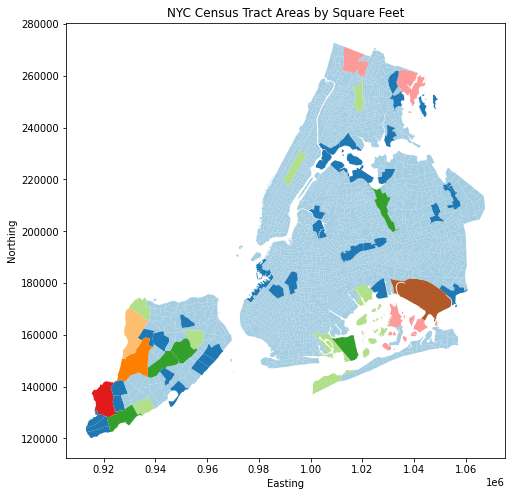

In [160]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ct_shape.plot(column="shape_area", alpha=1, linewidth=0.5,
              ax=ax, cmap="Paired")
plt.title("NYC Census Tract Areas by Square Feet");

Make a chloropleth using shape_areami2. Looks the same!

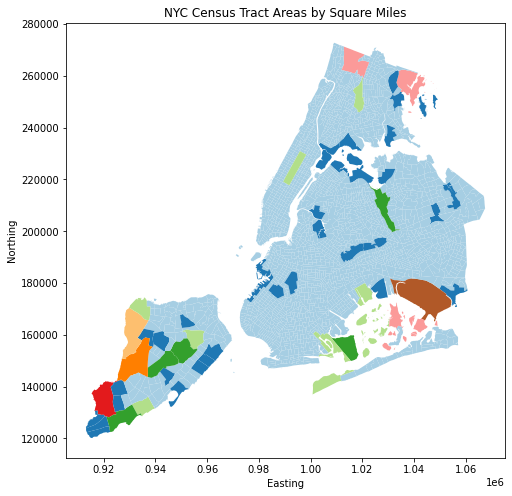

In [161]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ct_shape.plot(column="shape_areami2", alpha=1, linewidth=0.5,
              ax=ax, cmap="Paired")
plt.title("NYC Census Tract Areas by Square Miles");

*Fed notes: Put some numerical values to the colors. you can do this by adding the argument*

```legend=True```

 *to the choropleth gdp.plot() call*

 Mapping NYC census tracts with a legend for the sizes.

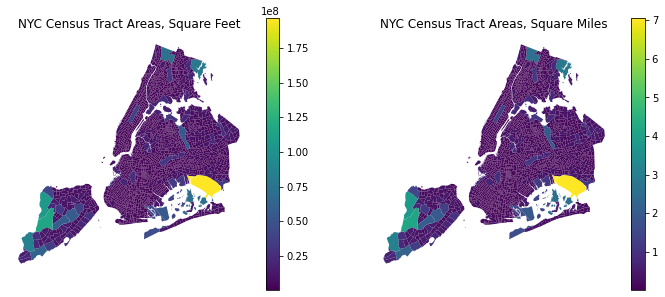

In [162]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ct_shape.plot(column="shape_area", legend=True, ax=ax)
plt.title("NYC Census Tract Areas, Square Feet")
ax.axis('off');
ax = fig.add_subplot(122)
ct_shape.plot(column="shape_areami2", legend=True, ax=ax)
plt.title("NYC Census Tract Areas, Square Miles")
ax.axis('off');

Using MapClassify to plot the distribution quantiles:

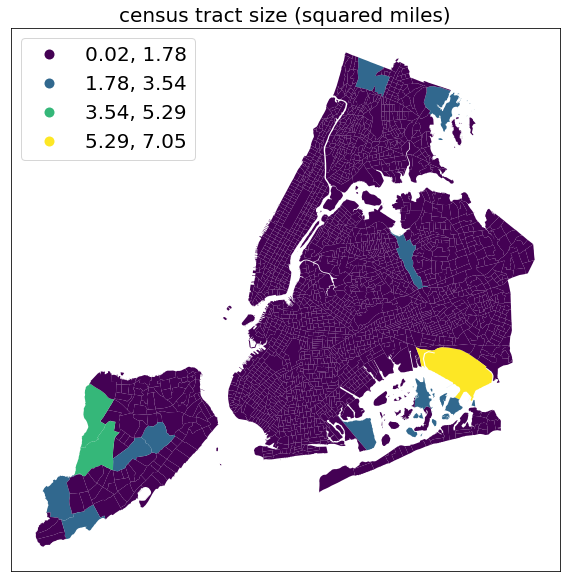

In [163]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='shape_areami2', cmap='viridis', alpha=1,
              linewidth=0.1, ax=ax, scheme="Equal_interval", 
              legend=True, k=4, legend_kwds={'loc': 'upper left', 'fontsize':20});
plt.title("census tract size (squared miles)", fontsize=20);

*Fed Notes: (At some point i got so tired of moving the legend around that i made a whole package to plot choropleths of NYC https://github.com/fedhere/choroplethNYC )*

# 2. Explore CitiBike data

2.1 Load CitiBike data for 9/2016


In [164]:
cb201609 = pd.read_csv("https://s3.amazonaws.com/tripdata/201609-citibike-tripdata.zip", index_col='starttime')
cb201609.head()

,tripduration,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
starttime,,,,,,,,,,,,,,
9/1/2016 00:00:02,975,9/1/2016 00:16:18,312,Allen St & Stanton St,40.722055,-73.989111,313,Washington Ave & Park Ave,40.696102,-73.967510,22609,Subscriber,1985.0,1
9/1/2016 00:00:04,1220,9/1/2016 00:20:25,316,Fulton St & William St,40.709560,-74.006536,239,Willoughby St & Fleet St,40.691966,-73.981302,16966,Subscriber,1977.0,2
9/1/2016 00:00:19,308,9/1/2016 00:05:27,479,9 Ave & W 45 St,40.760193,-73.991255,448,W 37 St & 10 Ave,40.756604,-73.997901,25601,Subscriber,1983.0,1
9/1/2016 00:00:25,250,9/1/2016 00:04:35,297,E 15 St & 3 Ave,40.734232,-73.986923,487,E 20 St & FDR Drive,40.733143,-73.975739,22094,Subscriber,1953.0,1
9/1/2016 00:00:25,439,9/1/2016 00:07:45,494,W 26 St & 8 Ave,40.747348,-73.997236,533,Broadway & W 39 St,40.752996,-73.987216,16319,Subscriber,1985.0,1


## 2.2 Exploring the Dataset

In [165]:
#Here are the different columns
cb201609.columns

Index(['tripduration', 'stoptime', 'start station id', 'start station name',
       'start station latitude', 'start station longitude', 'end station id',
       'end station name', 'end station latitude', 'end station longitude',
       'bikeid', 'usertype', 'birth year', 'gender'],
      dtype='object')

In [166]:
# Here is infor about what is in the columns and what kind of data they are
cb201609.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1648856 entries, 9/1/2016 00:00:02 to 9/30/2016 23:59:51
Data columns (total 14 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   tripduration             1648856 non-null  int64  
 1   stoptime                 1648856 non-null  object 
 2   start station id         1648856 non-null  int64  
 3   start station name       1648856 non-null  object 
 4   start station latitude   1648856 non-null  float64
 5   start station longitude  1648856 non-null  float64
 6   end station id           1648856 non-null  int64  
 7   end station name         1648856 non-null  object 
 8   end station latitude     1648856 non-null  float64
 9   end station longitude    1648856 non-null  float64
 10  bikeid                   1648856 non-null  int64  
 11  usertype                 1648856 non-null  object 
 12  birth year               1433341 non-null  float64
 13  gender              

There are 14 columns, about an even mix of float64, integers, and object. They have equal non-null counts except birth year, which is missing for about 215,000 entries. Also, it's a LOT of data. The geospatial information is stored in the start station latitude/start station longitude columns, so it's not an explicitly geospatial dataset, I think.

## 2.3 Map CitiBike Data at the census tract level

### Create a stations dataframe with spatial info

In [167]:
#Creating a stations dataframe with spatial info, groupby station
#Take the first row of each group, name the new dataframe
cbstations = cb201609.groupby("start station name").first()
cbstations.head()

,tripduration,stoptime,start station id,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
start station name,,,,,,,,,,,,,
1 Ave & E 16 St,827,9/1/2016 00:20:05,504,40.732219,-73.981656,412,Forsyth St & Canal St,40.715815,-73.994224,15861,Subscriber,1992.0,1
1 Ave & E 18 St,806,9/1/2016 00:45:53,2003,40.733812,-73.980544,442,W 27 St & 7 Ave,40.746647,-73.993915,23708,Subscriber,1967.0,1
1 Ave & E 30 St,801,9/1/2016 00:17:38,536,40.741444,-73.975361,301,E 2 St & Avenue B,40.722174,-73.983688,23634,Subscriber,1991.0,2
1 Ave & E 44 St,482,9/1/2016 07:27:56,455,40.750020,-73.969053,3155,Lexington Ave & E 63 St,40.764400,-73.966490,25935,Subscriber,1968.0,1
1 Ave & E 62 St,1310,9/1/2016 00:44:49,3142,40.761227,-73.960940,3301,Columbus Ave & W 95 St,40.791956,-73.968087,26950,Subscriber,1986.0,1


### Create CitiBike station Geometry (Point) from Coordinates (Lat & Lon) with Shapely

In [168]:
cbstations["lonlat"] = cbstations[["start station longitude", "start station latitude"]].apply(lambda x: 
                          Point(x["start station longitude"], x["start station latitude"]), axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [169]:
# I need to use matplotlib colormaps to map colors to variables' values
from matplotlib import cm

Now there is a geometry column with point data, thanks to Shapely

In [170]:
cbstations.head()

,tripduration,stoptime,start station id,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,lonlat
start station name,,,,,,,,,,,,,,
1 Ave & E 16 St,827,9/1/2016 00:20:05,504,40.732219,-73.981656,412,Forsyth St & Canal St,40.715815,-73.994224,15861,Subscriber,1992.0,1,POINT (-73.98165557 40.73221853)
1 Ave & E 18 St,806,9/1/2016 00:45:53,2003,40.733812,-73.980544,442,W 27 St & 7 Ave,40.746647,-73.993915,23708,Subscriber,1967.0,1,POINT (-73.98054420948029 40.73381219196632)
1 Ave & E 30 St,801,9/1/2016 00:17:38,536,40.741444,-73.975361,301,E 2 St & Avenue B,40.722174,-73.983688,23634,Subscriber,1991.0,2,POINT (-73.97536082 40.74144387)
1 Ave & E 44 St,482,9/1/2016 07:27:56,455,40.750020,-73.969053,3155,Lexington Ave & E 63 St,40.764400,-73.966490,25935,Subscriber,1968.0,1,POINT (-73.96905301 40.75001986)
1 Ave & E 62 St,1310,9/1/2016 00:44:49,3142,40.761227,-73.960940,3301,Columbus Ave & W 95 St,40.791956,-73.968087,26950,Subscriber,1986.0,1,POINT (-73.96094022 40.7612274)


### Plot the stations

In [171]:
# 1. Making a GeoDataFrame for cbstations
cbstations = gpd.GeoDataFrame(cbstations)

In [172]:
# 2. Every geodataframe needs a geometry column: assign latlon to the "geometry"
cbstations["geometry"]=cbstations["lonlat"]

In [173]:
# 3. Setting the CRS to EPSG:4326 (unprojected!)
cbstations = cbstations.set_crs("EPSG:4326")

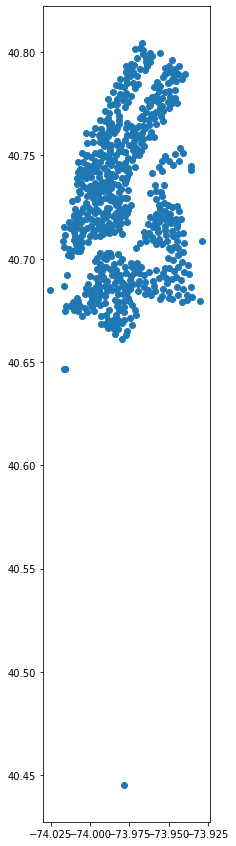

In [174]:
# 4. Plot the stations. Axes are still in coordinates.
ax = cbstations.plot(figsize=(15,15))

Convert the geometry projection to the same one you used for the NYC census tracts and replot with the census tracts map in the background


In [175]:
#Converting the projection to EPSG:2263, same as census tracts
cbstationsNY = cbstations.to_crs("EPSG:2263")
cbstationsNY.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Plot of Citibike station locations over census tract borders

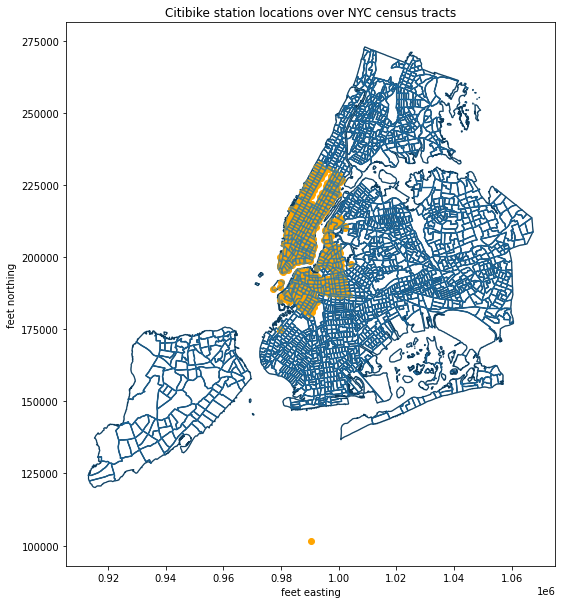

In [176]:
f, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("feet easting")
ax.set_ylabel("feet northing")
ct_shape.boundary.plot(ax=ax, alpha=0.5)
ct_shape.plot(ax=ax, color="None", edgecolor='k')
plt.title("Citibike station locations over NYC census tracts")
cbstationsNY.plot(ax=ax, c="Orange");

### Cleaning out that stray waterlogged station

In [177]:
# Finding the latitude of the bad station
cbstationsNY["start station latitude"].min()

40.44535

In [178]:
# Now the data excludes entries below that latitude.
cbstationsNY = cbstationsNY[cbstationsNY["start station latitude"] > 40.44535]

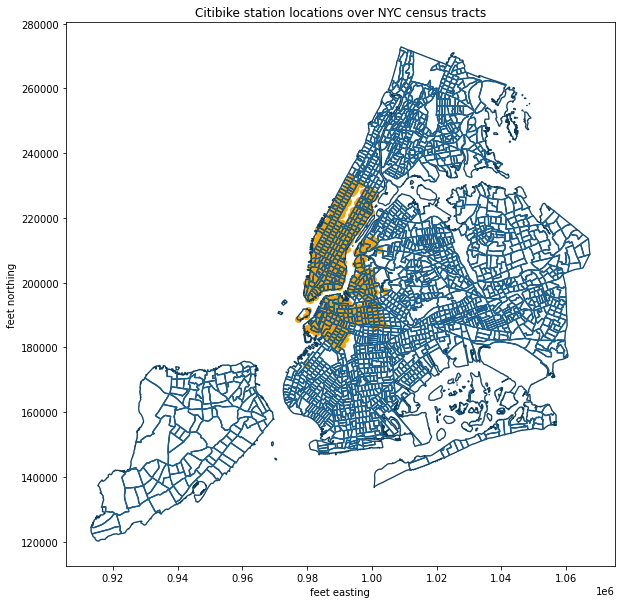

In [179]:
#replot it with fixed data
f, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("feet easting")
ax.set_ylabel("feet northing")
plt.title("Citibike station locations over NYC census tracts")
cbstationsNY.plot(ax=ax, c="Orange")
ct_shape.boundary.plot(ax=ax, alpha=0.5)
ct_shape.plot(ax=ax, color="None", edgecolor='k');

### Zoom into the relevant area of the map with set_xlim and set_ylim

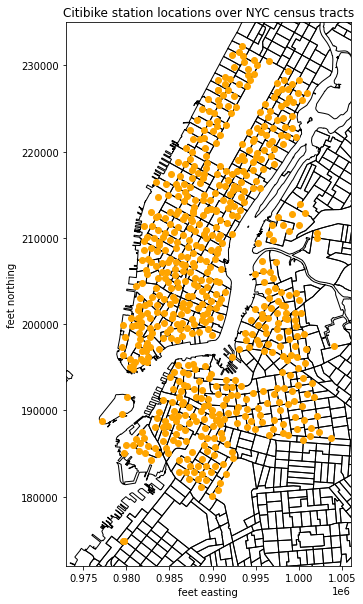

In [180]:
f, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("feet easting")
ax.set_ylabel("feet northing")
plt.title("Citibike station locations over NYC census tracts")
ax.set_xlim(left=0.973*1e6, right=1.006*1e6)
ax.set_ylim(bottom=172000, top=235000)
#ct_shape.boundary.plot(ax=ax, alpha=0.5)
ct_shape.plot(ax=ax, color="None", edgecolor="k")
cbstationsNY.plot(ax=ax, c="Orange");

# 3 Assigning points to polygons


## 3.1 Assign each station to a Borough

### Intersect the census tract and citi bikes geometries manually

*Fed Notes: First, let me do this by intersecting the shapes "manually" in a for loop. This should be transparent as far as the syntax go but it is very computationally inefficient.*

In [181]:
cbstationsNY["boro_name"] = ''
# check for each citibike stations to see what CT they belong to
for i in cbstationsNY.index:
    a = ct_shape[ct_shape.geometry.intersects(
        cbstationsNY.loc[i].geometry)]["boro_name"].values[0]
    cbstationsNY.loc[i,"boro_name"] = a


In [182]:
#Now they have a boro
cbstationsNY.head()

,tripduration,stoptime,start station id,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,lonlat,geometry,boro_name
start station name,,,,,,,,,,,,,,,,
1 Ave & E 16 St,827,9/1/2016 00:20:05,504,40.732219,-73.981656,412,Forsyth St & Canal St,40.715815,-73.994224,15861,Subscriber,1992.0,1,POINT (-73.98165557 40.73221853),POINT (989334.101 206044.065),Manhattan
1 Ave & E 18 St,806,9/1/2016 00:45:53,2003,40.733812,-73.980544,442,W 27 St & 7 Ave,40.746647,-73.993915,23708,Subscriber,1967.0,1,POINT (-73.98054420948029 40.73381219196632),POINT (989641.982 206624.752),Manhattan
1 Ave & E 30 St,801,9/1/2016 00:17:38,536,40.741444,-73.975361,301,E 2 St & Avenue B,40.722174,-73.983688,23634,Subscriber,1991.0,2,POINT (-73.97536082 40.74144387),POINT (991077.725 209405.575),Manhattan
1 Ave & E 44 St,482,9/1/2016 07:27:56,455,40.750020,-73.969053,3155,Lexington Ave & E 63 St,40.764400,-73.966490,25935,Subscriber,1968.0,1,POINT (-73.96905301 40.75001986),POINT (992824.569 212530.637),Manhattan
1 Ave & E 62 St,1310,9/1/2016 00:44:49,3142,40.761227,-73.960940,3301,Columbus Ave & W 95 St,40.791956,-73.968087,26950,Subscriber,1986.0,1,POINT (-73.96094022 40.7612274),POINT (995070.581 216614.806),Manhattan


### overplot the map locations on top of the census tract boundaries in the zoom in version (as before) but this time color the points by NYC Borough

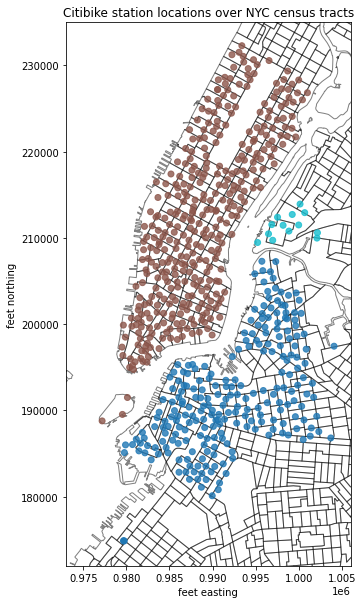

In [183]:
f, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("feet easting")
ax.set_ylabel("feet northing")
plt.title("Citibike station locations over NYC census tracts")
ax.set_xlim(left=0.973*1e6, right=1.006*1e6)
ax.set_ylim(bottom=172000, top=235000)
#ct_shape.boundary.plot(ax=ax, zorder = 1, alpha=0)
ct_shape.plot(ax=ax, color="None", edgecolor="k", alpha = 0.5)
cbstationsNY.plot(ax=ax, column="boro_name", c="Paired", alpha=0.8);

## 3.2 Create a chloropleth of NYC census tracts where the color maps to the number of citibike stations

### Perform a spatial join

*Fed Notes: Perfoming an $n \times m$ intersection test is horrifically inefficient and slow. Spatial joins use an R-tree for spatial indexing to rapidly join the tables on their geometries.*

*Spatial joins operate on objects with eastings and northings, i.e., you must use two geodataframs with the same CRS, and that needs ot be a CRS expressed with dimensioned lengths. This will NOT work on data expressed in lat/long. Use* ```geopandas.tools.sjoin()``` 
*passing to it ct_shape and cbstations to get a dataframe that for every station row has the census tract value in a ```boro_ct2010``` column*

In [184]:
# Here is my spatial join!
cbstationsWct = gpd.tools.sjoin(ct_shape, cbstationsNY)
cbstationsWct

,ntacode,shape_area,ntaname,shape_leng,boro_name_left,puma,ct2010,boro_code,cdeligibil,boro_ct2010,...,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,lonlat,boro_name_right
1,MN19,1.906016e+06,Turtle Bay-East Midtown,5534.20030825,Manhattan,3808,009800,1,I,1009800,...,3140,1 Ave & E 78 St,40.771404,-73.953517,19938,Customer,1990.0,0,POINT (-73.96592976 40.75455731),Manhattan
1,MN19,1.906016e+06,Turtle Bay-East Midtown,5534.20030825,Manhattan,3808,009800,1,I,1009800,...,401,Allen St & Rivington St,40.720196,-73.989978,15618,Subscriber,1992.0,1,POINT (-73.967416 40.756014),Manhattan
2,MN17,1.860993e+06,Midtown-Midtown South,5687.80243891,Manhattan,3807,010200,1,I,1010200,...,530,11 Ave & W 59 St,40.771522,-73.990541,24994,Subscriber,1965.0,1,POINT (-73.97402311 40.7597108),Manhattan
2,MN17,1.860993e+06,Midtown-Midtown South,5687.80243891,Manhattan,3807,010200,1,I,1010200,...,305,E 58 St & 3 Ave,40.760958,-73.967245,25802,Subscriber,1986.0,1,POINT (-73.972924 40.761628),Manhattan
3,MN17,1.864600e+06,Midtown-Midtown South,5693.03636707,Manhattan,3807,010400,1,I,1010400,...,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,20969,Subscriber,1986.0,1,POINT (-73.97648516 40.75992262),Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,BK99,2.740322e+07,park-cemetery-etc-Brooklyn,24250.8583554,Brooklyn,4005,017700,3,I,3017700,...,3354,3 St & Prospect Park West,40.668132,-73.973638,19360,Customer,1979.0,0,POINT (-73.97363831 40.668132),Brooklyn
2150,MN17,2.434420e+06,Midtown-Midtown South,6254.84415438,Manhattan,3807,013700,1,I,1013700,...,157,Henry St & Atlantic Ave,40.690893,-73.996123,19425,Subscriber,1982.0,1,POINT (-73.98192338 40.7652654),Manhattan
2150,MN17,2.434420e+06,Midtown-Midtown South,6254.84415438,Manhattan,3807,013700,1,I,1013700,...,3173,Riverside Blvd & W 67 St,40.777507,-73.988886,19303,Subscriber,1982.0,1,POINT (-73.98169333 40.76695317),Manhattan
2151,MN15,1.954944e+06,Clinton,5774.68293551,Manhattan,3807,013900,1,I,1013900,...,449,W 52 St & 9 Ave,40.764618,-73.987895,16842,Subscriber,1983.0,1,POINT (-73.988639 40.768254),Manhattan


### groupby the geodataframe resulting from the spatial join grouping based on the census tract (e.g. use "boro_ct2010") and _count_ the number of station per boro_ct2010 value



I don't know if I needed this, but here are the number of stations per census tract.

In [185]:
cbstationsWct.groupby("boro_ct2010").count()[["ntacode"]]

,ntacode
boro_ct2010,
1000202,3
1000500,3
1000600,3
1000700,7
1000800,2
...,...
4001900,3
4002500,1
4003300,1


Our little group got unnerved by not being able to see all the columns and the geometry advice, so I checked the full list of columns.

In [186]:
print(cbstationsWct.columns.tolist())

['ntacode', 'shape_area', 'ntaname', 'shape_leng', 'boro_name_left', 'puma', 'ct2010', 'boro_code', 'cdeligibil', 'boro_ct2010', 'ctlabel', 'geometry', 'shape_areami2', 'index_right', 'tripduration', 'stoptime', 'start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station name', 'end station latitude', 'end station longitude', 'bikeid', 'usertype', 'birth year', 'gender', 'lonlat', 'boro_name_right']


*Fed Notes: merge the geodataframe resulting from the spatial join + groupby  with the original census tract geodataframe. NOTE: you should remove the geometry column from the first dataframe before you merge cause you want the geometry to be inherited from the census tracts geodataframe. In fact, from the first geodataframe, you need _only_ one column that contains the number of stations for that geometry group.*


We also weren't sure if there was a special step we were supposed to do ensure the geometry column was okay, because it seemed to work fine with what we did.

### Plot the census tracts in the background (in black and white) and overplot a coropleth of the number of stations per census tract: the latter is the geodataframe you produced above plotted with the column argument set to the column name of the column that contains the number of stations information

.... YOU ARE DONE!!

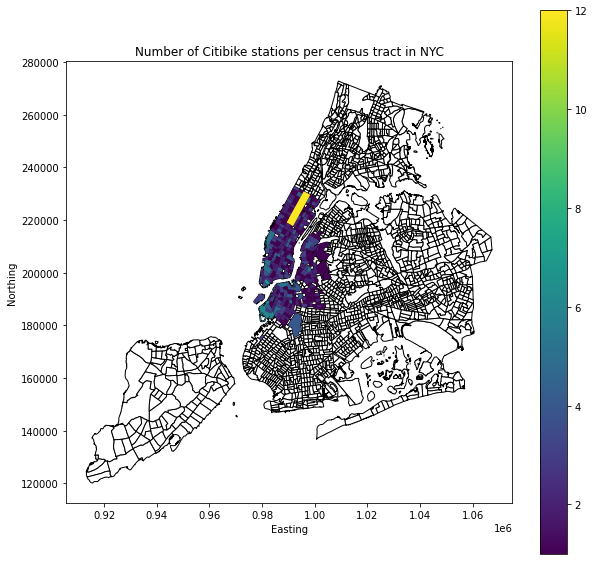

In [188]:
ctbycs = ct_shape.merge(cbstationsWct.groupby("boro_ct2010").count()[["ntacode"]], 
                        right_index=True, left_on="boro_ct2010")
ax = ct_shape.plot(ec="k", fc="w", figsize=(10,10))
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
plt.title("Number of Citibike stations per census tract in NYC")
ctbycs.plot(column="ntacode_y", legend=True, ax=ax)